In [1]:
import os
import numpy as np
import pandas as pd
import random
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms

import re
from collections import Counter
from transformers import (
    AutoConfig,
    AutoTokenizer, 
    AutoModel,
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorWithPadding,
    get_scheduler
)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

2025-07-25 03:20:13.829387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753413614.101200      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753413614.172969      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 0
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed)

In [4]:
# Generator untuk DataLoader
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    """Fungsi untuk memastikan setiap worker memiliki seed yang sama"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
# Paths
train_csv_path = '/kaggle/input/train-test/train_data.csv'
test_csv_path = '/kaggle/input/train-test/test_data.csv'

In [6]:
# Load data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [7]:
# Drop missing values
print('Missing values in Train:\n', train_df.isna().sum())
train_df = train_df.dropna()

Missing values in Train:
 File Name         0
Extracted Text    0
Class             0
dtype: int64


In [8]:
import re

def clean_texts(texts):
    cleaned_texts = []

    # Kata 1–2 huruf yang penting dan tidak boleh dihapus
    exceptions = {"di", "ke", "ya", "jl"}

    for text in texts:
        # ----- BASIC CLEANING -----
        text = re.sub(r"http\S+", "", text)                    # Hapus URL
        text = re.sub(r"\n", " ", text)                        # Ganti newline dengan spasi
        text = re.sub(r"[^a-zA-Z]", " ", text)             # Sisakan huruf, angka, apostrof
        text = re.sub(r"\s{2,}", " ", text).strip().lower()    # Hapus spasi ganda & ke lowercase

        # ----- FILTERING -----
        words = text.split()
        filtered_words = [
            w for w in words
            if (len(w) > 2 or w in exceptions)
            and not re.fullmatch(r"[aeiou]{3,}", w)            # Hindari vokal berulang ("aaa")
            and not re.fullmatch(r"[bcdfghjklmnpqrstvwxyz]{3,}", w)  # Hindari konsonan berulang ("kkk")
            and len(w) <= 20                                   # Batasi kata terlalu panjang
        ]

        cleaned_texts.append(" ".join(filtered_words))

    return cleaned_texts

In [9]:
# # Clean text
train_df['cleaned_text'] = clean_texts(train_df['Extracted Text'])
test_df['cleaned_text'] = clean_texts(test_df['Extracted Text'])
# Gabungkan teks dari train dan test sementara
# combined_texts = pd.concat([train_df['Extracted Text'], test_df['Extracted Text']], ignore_index=True)

# # Bersihkan semua teks gabungan
# cleaned_all = clean_texts(combined_texts)

# # Bagi kembali hasil cleaned text ke dalam train dan test
# train_df['cleaned_text'] = cleaned_all[:len(train_df)]
# test_df['cleaned_text'] = cleaned_all[len(train_df):]

In [10]:
# Drop rows with less than 5 words
train_df = train_df[train_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
test_df = test_df[test_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
train_df

,File Name,Extracted Text,Class,cleaned_text
0,ahoyamigo.com_home.png,KASKUSTOTO LOGIN KASKUSTOTO oiocom KASKUSTOTO ...,judi,kaskustoto login kaskustoto oiocom kaskustoto ...
1,asgard789.bet.png,SUCKBET kunusn Tusluju Unajv ]acipısı aüns I...,judi,suckbet kunusn tusluju unajv acip augn
2,bola442.monster.png,AsF User Name Password Code 6636 LOGIN Lela442...,judi,asf user name password code login lela live ch...
3,maniac-ihokibet.com_page1.png,Download APK Live Chat Hubungı Kamı Lupa Kata ...,judi,download apk live chat hubung kam lupa kata sa...
4,ketohour.com_page4.png,ketohour Beranda 7 @ Q Subscribe Beranda Situs...,judi,ketohour beranda subscribe beranda situs togel...
...,...,...,...,...
3340,bankmandiri.co.id_home.png,Ketik untuk mencari Log In mandırı Perseoranga...,non-judi,ketik untuk mencari log mand perseorangan bisn...
3341,bengkaliskab.go.id_page3.png,"JL Ahmad Yani, Bengkalis Kota Selamat datang d...",non-judi,jl ahmad yani bengkalis kota selamat datang di...
3342,bsmentertainment.com_page9.png,021-22792541 CallWva 08111306600 (Jakarta) | C...,non-judi,callwva jakarta call wva bandurg office hours ...
3343,coinmarketcap.com_page5.png,CoinMarketCap Cryptocurrencies DexScan Exchang...,non-judi,coinmarketcap cryptocurrencies dexscan exchang...


In [11]:
# Cek jumlah duplikasi sebelum dihapus
print("Duplikasi di train:", train_df.duplicated(subset='cleaned_text').sum())
print("Duplikasi di test :", test_df.duplicated(subset='cleaned_text').sum())

# Hapus duplikasi berdasarkan cleaned_text
train_df = train_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)
test_df = test_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)

# Cek ulang setelah pembersihan
print("Setelah dihapus:")
print("Train:", len(train_df), "baris")
print("Test :", len(test_df), "baris")

Duplikasi di train: 8
Duplikasi di test : 0
Setelah dihapus:
Train: 3335 baris
Test : 700 baris


In [12]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(train_df['Class'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['Class'].value_counts())

Distribusi label di Train set:
Class
non-judi    1740
judi        1595
Name: count, dtype: int64 

Distribusi label di Test set:
Class
judi        350
non-judi    350
Name: count, dtype: int64


In [13]:
from sklearn.utils import resample

# Pisahkan data berdasarkan kelas
train_judi = train_df[train_df['Class'] == 'judi']
train_nonjudi = train_df[train_df['Class'] == 'non-judi']

# Undersampling kelas mayoritas (non-judi) agar jumlahnya sama dengan kelas judi
train_nonjudi_undersampled = resample(train_nonjudi,
                                      replace=False,      # tanpa duplikasi
                                      n_samples=len(train_judi),  # samakan jumlahnya dengan kelas minoritas
                                      random_state=seed)    # untuk replikasi hasil

# Gabungkan kembali data yang sudah diundersample
train_df_balanced = pd.concat([train_judi, train_nonjudi_undersampled])

# Cek distribusi baru
print("Distribusi label setelah undersampling:")
print(train_df_balanced['Class'].value_counts())

Distribusi label setelah undersampling:
Class
judi        1595
non-judi    1595
Name: count, dtype: int64


# ---------------------- WordCloud -------------------------
wordcloud tidak masuk ke dalam pipeline utama

## Menggunakan Stopword Removal dan Stemming

In [14]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


In [15]:
from wordcloud import WordCloud
from collections import Counter
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [16]:
# --- Setup Stopword dan Stemmer ---
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()

# Gabungkan stopword Indo + Inggris
combined_stopwords = stopwords.union(ENGLISH_STOP_WORDS)

In [17]:
# --- Preprocessing untuk WordCloud ---
def preprocess_for_wordcloud(text):
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in combined_stopwords]
    # words = [stemmer.stem(w) for w in words if w not in stopwords]
    return words  # kembalikan list token

# --- Plot WordCloud dan Tampilkan Frekuensi ---
def plot_wordcloud_and_freq(tokens, title, top_n=30):
    freq = Counter(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    
    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.generate_from_frequencies(freq), interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()
    
    # Tampilkan frekuensi top-N kata
    print(f"\nTop {top_n} kata paling sering muncul di {title}:\n")
    for word, count in freq.most_common(top_n):
        print(f"{word:<15} {count}")

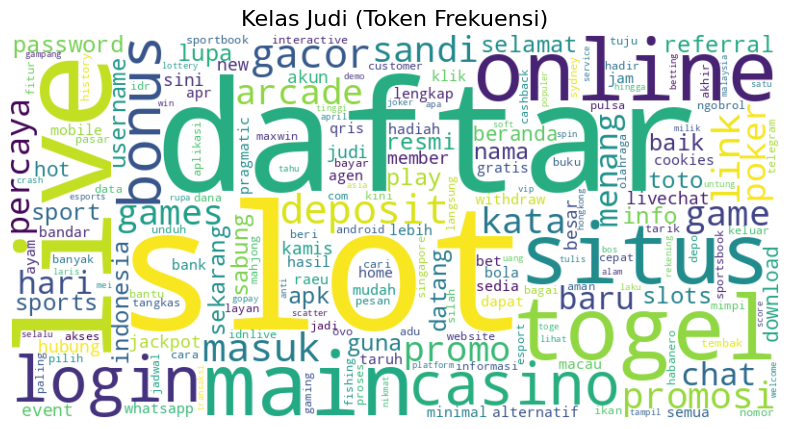


Top 30 kata paling sering muncul di Kelas Judi (Token Frekuensi):

slot            2270
daftar          1737
live            1202
togel           1179
main            1151
online          1098
situs           1078
login           939
casino          912
bonus           870
deposit         693
gacor           684
masuk           646
link            628
promosi         605
promo           568
game            559
arcade          550
kata            542
games           528
sandi           528
poker           470
percaya         441
chat            425
menang          413
baru            411
hari            408
password        390
slots           385
sekarang        380


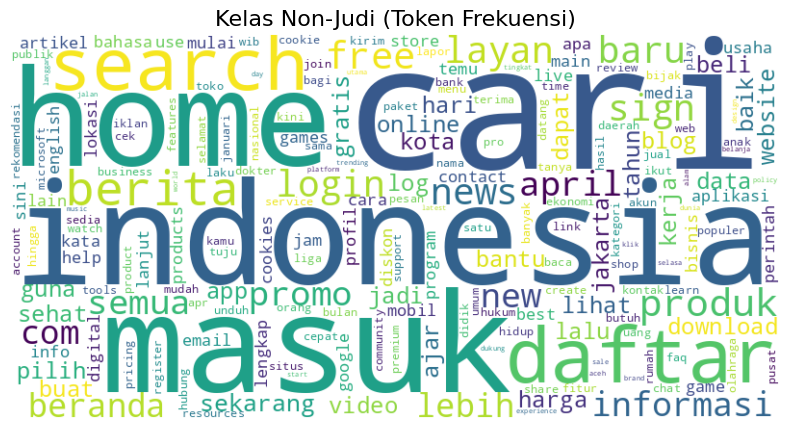


Top 30 kata paling sering muncul di Kelas Non-Judi (Token Frekuensi):

cari            430
indonesia       407
masuk           384
home            364
daftar          343
search          325
berita          294
produk          286
free            277
layan           268
sign            267
news            263
baru            263
login           257
promo           231
april           226
semua           225
new             211
informasi       211
com             197
lebih           196
beranda         194
sekarang        191
pilih           179
lihat           178
data            175
hari            171
tahun           171
online          169
log             168


In [18]:
# --- Kelas JUDI ---
judi_raw = ' '.join(train_df_balanced[train_df_balanced['Class'] == 'judi']['cleaned_text'])
judi_tokens = preprocess_for_wordcloud(judi_raw)
plot_wordcloud_and_freq(judi_tokens, 'Kelas Judi (Token Frekuensi)', top_n=30)

# --- Kelas NON-JUDI ---
nonjudi_raw = ' '.join(train_df_balanced[train_df_balanced['Class'] == 'non-judi']['cleaned_text'])
nonjudi_tokens = preprocess_for_wordcloud(nonjudi_raw)
plot_wordcloud_and_freq(nonjudi_tokens, 'Kelas Non-Judi (Token Frekuensi)', top_n=30)

# --------------------------------------------------------------